In [1]:
# Import required libraries
# Data manipulation and visualization libraries
import pandas as pd  # For data manipulation
import numpy as np   # For numerical operations
%matplotlib inline  
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For enhanced visualization
import os  # For operating system interactions
import datetime as dt  # For date/time operations

# Clustering libraries
import sklearn  # Machine learning library
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.cluster import KMeans  # K-Means clustering algorithm
from sklearn.metrics import silhouette_score  # For cluster evaluation
from scipy.cluster.hierarchy import linkage  # For hierarchical clustering
from scipy.cluster.hierarchy import dendrogram  # For dendrogram visualization
from scipy.cluster.hierarchy import cut_tree  # For cutting dendrogram

In [2]:
# Load and inspect data
raw_data = pd.read_excel('online_retail_II.xlsx')  # Load dataset from Excel file
df = raw_data.copy()  # Create a working copy
df.head(10)  # Display first 10 rows

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [3]:
# Check dataset shape
df.shape  # Show dimensions of dataset (rows, columns)

(525461, 8)

In [4]:
# Check dataset information
df.info()  # Display data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [5]:
# Generate descriptive statistics
df.describe()  # Show summary statistics for numerical columns

,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


# Cleaning the data

In [6]:
# Check for missing values
df.isnull().sum()  # Count missing values per column

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [9]:
# Handle missing values
df = df.dropna()  # Remove rows with missing values
df.shape

(417534, 8)

In [10]:
# Convert Customer ID to string
df['Customer ID'] = df['Customer ID'].astype(str)  # Convert to string for categorical handling


# Customer RFM Analysis

In [12]:
# Calculate monetary value
df['Amount'] = df['Quantity'] * df['Price']  # Create transaction amount column
df_grouped_aggregated = df.groupby('Customer ID')['Amount'].sum()  # Sum per customer
df_grouped_aggregated = df_grouped_aggregated.reset_index()  # Convert to DataFrame
df_grouped_aggregated.head(10)  # Show first 10 customers


,Customer ID,Amount
0,12346.0,-64.68
1,12347.0,1323.32
2,12348.0,222.16
3,12349.0,2646.99
4,12351.0,300.93
5,12352.0,343.80
6,12353.0,317.76
7,12355.0,488.21
8,12356.0,3562.25
9,12357.0,12079.99


In [13]:
# Calculate frequency
df_grouped_frequency = df.groupby('Customer ID')['Invoice'].count()  # Count transactions per customer
df_grouped_frequency = df_grouped_frequency.reset_index()  # Convert to DataFrame
df_grouped_frequency.columns = ['Customer ID', 'Frequency']  # Rename columns
df_grouped_frequency  # Display full frequency data

,Customer ID,Frequency
0,12346.0,46
1,12347.0,71
2,12348.0,20
3,12349.0,107
4,12351.0,21
...,...,...
4378,18283.0,230
4379,18284.0,29
4380,18285.0,12
4381,18286.0,70


In [14]:
# Merge monetary and frequency data
df_merged = pd.merge(df_grouped_aggregated, df_grouped_frequency, on='Customer ID', how='inner')  # Inner join
df_merged.head(10)  # Show merged data


,Customer ID,Amount,Frequency
0,12346.0,-64.68,46
1,12347.0,1323.32,71
2,12348.0,222.16,20
3,12349.0,2646.99,107
4,12351.0,300.93,21
5,12352.0,343.80,18
6,12353.0,317.76,20
7,12355.0,488.21,22
8,12356.0,3562.25,84
9,12357.0,12079.99,165


In [15]:
# Calculate recency
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')  # Convert to datetime

In [16]:
# Find latest transaction date
max_date = max(df['InvoiceDate'])  # Most recent transaction date
max_date  # Display result

Timestamp('2010-12-09 20:01:00')

In [17]:
# Calculate days since last transaction
df['date_diff'] = max_date - df['InvoiceDate']  # Time delta since last transaction
df.head(10)  # Show with new column

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount,date_diff
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,373 days 12:16:00
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,373 days 12:16:00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,373 days 12:16:00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,373 days 12:16:00
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,373 days 12:16:00
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom,39.6,373 days 12:16:00
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,373 days 12:16:00
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom,59.5,373 days 12:16:00
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom,30.6,373 days 12:15:00
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom,45.0,373 days 12:15:00


In [18]:
# Find customer recency
df_recency = df.groupby('Customer ID')['date_diff'].min()  # Get last transaction per customer
df_recency = df_recency.reset_index()  # Convert to DataFrame
df_recency.head(10)  # Display recency data

,Customer ID,date_diff
0,12346.0,66 days 03:28:00
1,12347.0,2 days 05:04:00
2,12348.0,73 days 05:02:00
3,12349.0,42 days 11:38:00
4,12351.0,10 days 04:38:00
5,12352.0,10 days 09:54:00
6,12353.0,43 days 07:17:00
7,12355.0,202 days 08:02:00
8,12356.0,15 days 07:37:00
9,12357.0,23 days 05:32:00


In [19]:
# Convert recency to days
df_recency['date_diff'] = df_recency['date_diff'].dt.days  # Extract number of days
df_recency.head(10)  # Show numerical recency values

,Customer ID,date_diff
0,12346.0,66
1,12347.0,2
2,12348.0,73
3,12349.0,42
4,12351.0,10
5,12352.0,10
6,12353.0,43
7,12355.0,202
8,12356.0,15
9,12357.0,23


In [20]:
# Create RFM dataframe
df_rfm = pd.merge(df_merged, df_recency, on='Customer ID', how='inner')  # Combine RFM metrics
df_rfm.head(10)  # Display RFM data

,Customer ID,Amount,Frequency,date_diff
0,12346.0,-64.68,46,66
1,12347.0,1323.32,71,2
2,12348.0,222.16,20,73
3,12349.0,2646.99,107,42
4,12351.0,300.93,21,10
5,12352.0,343.80,18,10
6,12353.0,317.76,20,43
7,12355.0,488.21,22,202
8,12356.0,3562.25,84,15
9,12357.0,12079.99,165,23


In [21]:
# Cell 20: Rename columns
df_rfm.columns = ['Customer ID', 'Amount', 'Frequency', 'Recency']  # Standardize column names
df_rfm.head(10)  # Show final RFM structure

,Customer ID,Amount,Frequency,Recency
0,12346.0,-64.68,46,66
1,12347.0,1323.32,71,2
2,12348.0,222.16,20,73
3,12349.0,2646.99,107,42
4,12351.0,300.93,21,10
5,12352.0,343.80,18,10
6,12353.0,317.76,20,43
7,12355.0,488.21,22,202
8,12356.0,3562.25,84,15
9,12357.0,12079.99,165,23


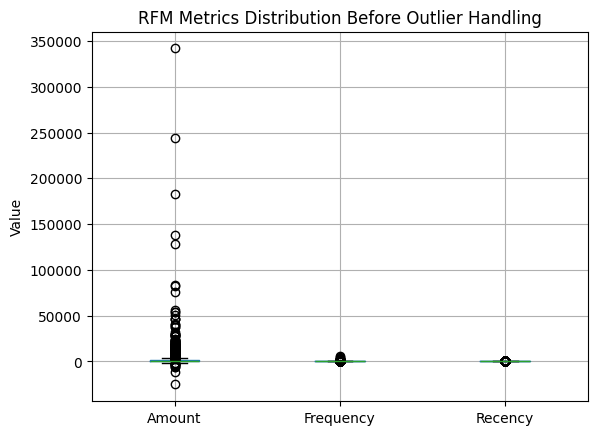

In [22]:
# Visualize distribution of RFM metrics
df_rfm.boxplot()  # Box plot to identify outliers
plt.title('RFM Metrics Distribution Before Outlier Handling')
plt.ylabel('Value')
plt.show()

In [24]:
# Handle outliers using IQR method
# Amount outliers
Q1_amt = df_rfm.Amount.quantile(0.05)
Q3_amt = df_rfm.Amount.quantile(0.95)
IQR_amt = Q3_amt - Q1_amt
df_rfm = df_rfm[(df_rfm.Amount >= Q1_amt - 1.5*IQR_amt) & 
                (df_rfm.Amount <= Q3_amt + 1.5*IQR_amt)]

# Recency outliers
Q1_rec = df_rfm.Recency.quantile(0.05)
Q3_rec = df_rfm.Recency.quantile(0.95)
IQR_rec = Q3_rec - Q1_rec
df_rfm = df_rfm[(df_rfm.Recency >= Q1_rec - 1.5*IQR_rec) & 
                (df_rfm.Recency <= Q3_rec + 1.5*IQR_rec)]

# Frequency outliers
Q1_freq = df_rfm.Frequency.quantile(0.05)
Q3_freq = df_rfm.Frequency.quantile(0.95)
IQR_freq = Q3_freq - Q1_freq
df_rfm = df_rfm[(df_rfm.Frequency >= Q1_freq - 1.5*IQR_freq) & 
                (df_rfm.Frequency <= Q3_freq + 1.5*IQR_freq)]


In [25]:
# Prepare data for clustering
df_frm_no_customerID = df_rfm[['Amount', 'Frequency', 'Recency']]  # Select relevant columns

In [26]:
# Scale features
scaler = StandardScaler()  # Initialize scaler
df_rfm_scaled = scaler.fit_transform(df_frm_no_customerID)  # Standardize features
df_rfm_scaled.shape  # Show dimensions of scaled data

(4287, 3)

In [27]:
# Create scaled DataFrame
df_rfm_scaled = pd.DataFrame(df_rfm_scaled)  # Convert to DataFrame
df_rfm_scaled.columns = ['Amount', 'Frequency', 'Recency']  # Rename columns
df_rfm_scaled.head(10)  # Show scaled data

,Amount,Frequency,Recency
0,-0.775623,-0.328802,-0.263550
1,0.046826,-0.079650,-0.913514
2,-0.605658,-0.587920,-0.192461
3,0.831156,0.279129,-0.507287
4,-0.558984,-0.577954,-0.832269
5,-0.533581,-0.607852,-0.832269
6,-0.549011,-0.587920,-0.497131
7,-0.448012,-0.567987,1.117623
8,1.373487,0.049909,-0.781491
9,0.873831,-0.209209,-0.832269


# Building the model

In [28]:
# Initial K-Means model
kmeans = KMeans(n_clusters=4, max_iter=50)  # Initialize with 4 clusters
kmeans.fit(df_rfm_scaled)  # Fit model to scaled data

KMeans(max_iter=50, n_clusters=4)

In [29]:
# View cluster labels
kmeans.labels_  # Show assigned cluster labels

array([3, 3, 3, ..., 0, 3, 1])

# Using Elbow Method

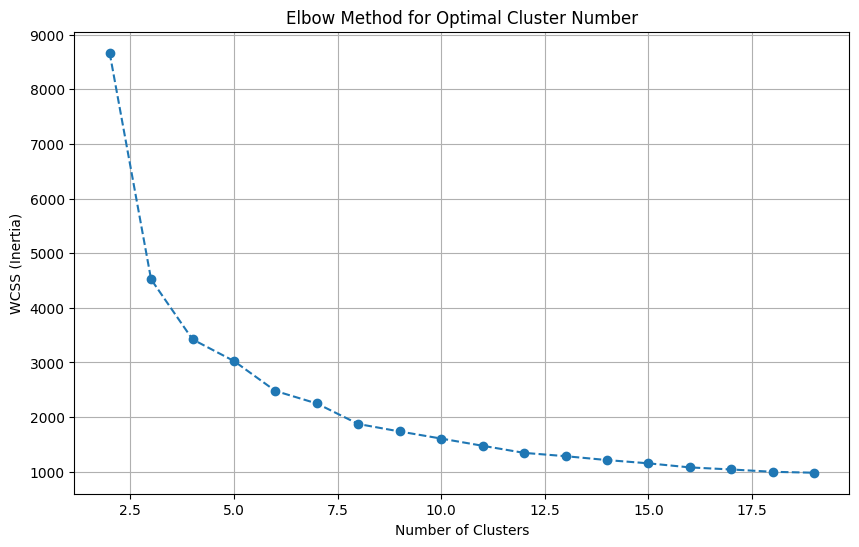

In [30]:
# Elbow method implementation
wcss = []  # Within-Cluster Sum of Squares
range_n_clusters = range(2, 20)  # Test 2 to 19 clusters

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)  # Initialize K-Means
    kmeans.fit(df_rfm_scaled)  # Fit model
    wcss.append(kmeans.inertia_)  # Store WCSS value

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, wcss, marker='o', linestyle='--') 
plt.title('Elbow Method for Optimal Cluster Number')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)
plt.show()


In [31]:
# View WCSS values
wcss  # Display WCSS values for inspection

[8669.315305935836,
 4521.707086808895,
 3422.975860585405,
 3026.4670476901083,
 2479.3476454979386,
 2249.4112709529554,
 1874.1481423733135,
 1737.216262629699,
 1607.336799096298,
 1475.6405969780499,
 1345.8036253449825,
 1285.3087401320165,
 1214.1453628593908,
 1154.4519433626706,
 1079.7501736323543,
 1041.8231639159158,
 999.2698803032326,
 982.4535586210718]

# Silhouette Analysis

For n_clusters=2, silhouette score=0.5123
For n_clusters=3, silhouette score=0.4995
For n_clusters=4, silhouette score=0.4725
For n_clusters=5, silhouette score=0.4113
For n_clusters=6, silhouette score=0.3961
For n_clusters=7, silhouette score=0.3963
For n_clusters=8, silhouette score=0.3826
For n_clusters=9, silhouette score=0.3524
For n_clusters=10, silhouette score=0.3415
For n_clusters=11, silhouette score=0.3327
For n_clusters=12, silhouette score=0.3371
For n_clusters=13, silhouette score=0.3400
For n_clusters=14, silhouette score=0.3282
For n_clusters=15, silhouette score=0.3251
For n_clusters=16, silhouette score=0.3210
For n_clusters=17, silhouette score=0.3250
For n_clusters=18, silhouette score=0.3177
For n_clusters=19, silhouette score=0.3063


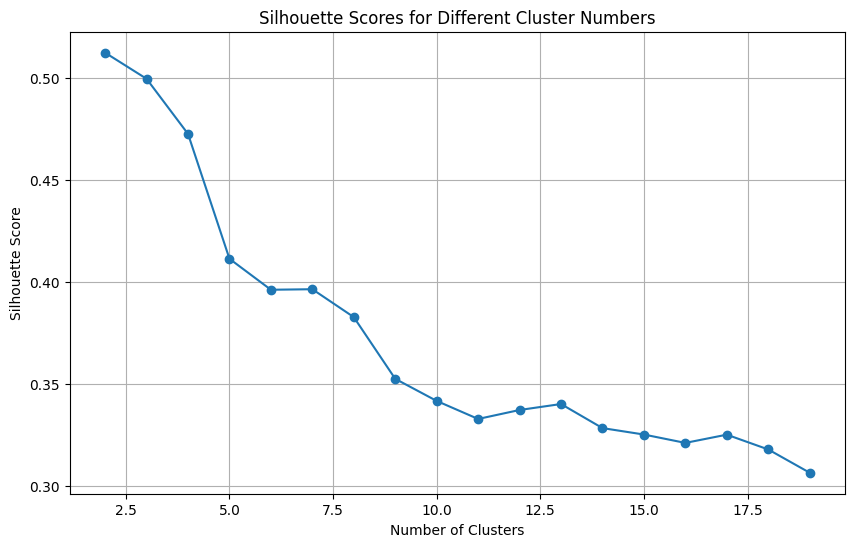

In [32]:
# Silhouette score calculation
range_n_clusters = range(2, 20)  # Test 2 to 19 clusters
silhouette_scores = []  # Store silhouette scores

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)  # Initialize K-Means
    kmeans.fit(df_rfm_scaled)  # Fit model
    cluster_labels = kmeans.labels_  # Get cluster assignments
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(df_rfm_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters={num_clusters}, silhouette score={silhouette_avg:.4f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Cluster Numbers')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


In [47]:
# Final K-Means model
num_clusters = 3  # Optimal from silhouette analysis
kmeans = KMeans(n_clusters=num_clusters, max_iter=50, random_state=42)  # Initialize
kmeans.fit(df_rfm_scaled)  # Fit model




KMeans(max_iter=50, n_clusters=3, random_state=42)

In [48]:
# View final cluster labels
kmeans.labels_  # Show final cluster assignments

array([0, 0, 0, ..., 1, 0, 0])

In [49]:
# Add clusters to RFM data
df_rfm['ClusterID'] = kmeans.labels_  # Add cluster IDs
df_rfm.head(10)  # Show data with clusters


,Customer ID,Amount,Frequency,Recency,ClusterID,Hierarchical_Cluster
0,12346.0,-64.68,46,66,0,0
1,12347.0,1323.32,71,2,0,0
2,12348.0,222.16,20,73,0,0
3,12349.0,2646.99,107,42,0,0
4,12351.0,300.93,21,10,0,0
5,12352.0,343.80,18,10,0,0
6,12353.0,317.76,20,43,0,0
7,12355.0,488.21,22,202,1,0
8,12356.0,3562.25,84,15,0,0
10,12358.0,2719.01,58,10,0,0


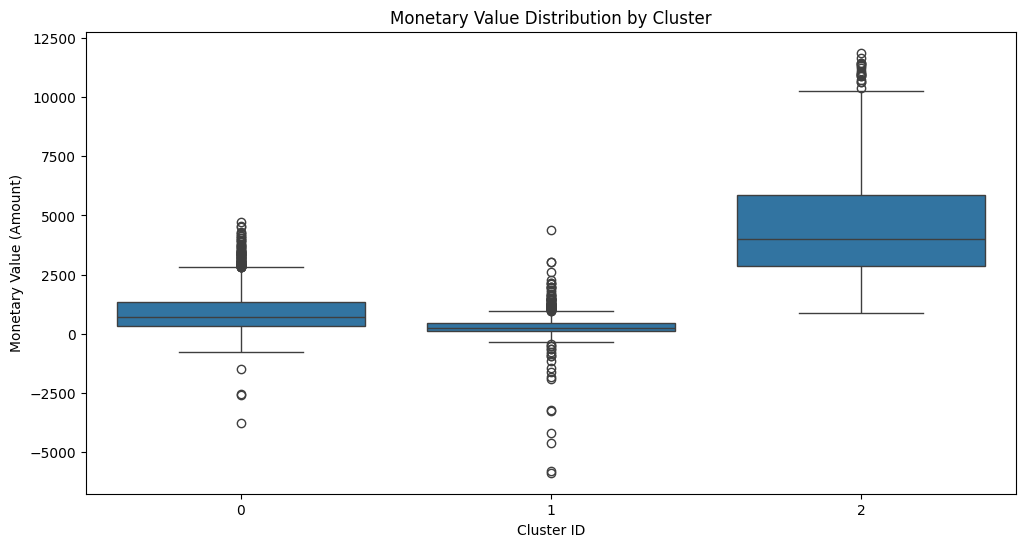

In [50]:
# Monetary value by cluster
plt.figure(figsize=(12, 6))
sns.boxplot(x='ClusterID', y='Amount', data=df_rfm)
plt.title('Monetary Value Distribution by Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Monetary Value (Amount)')
plt.show()


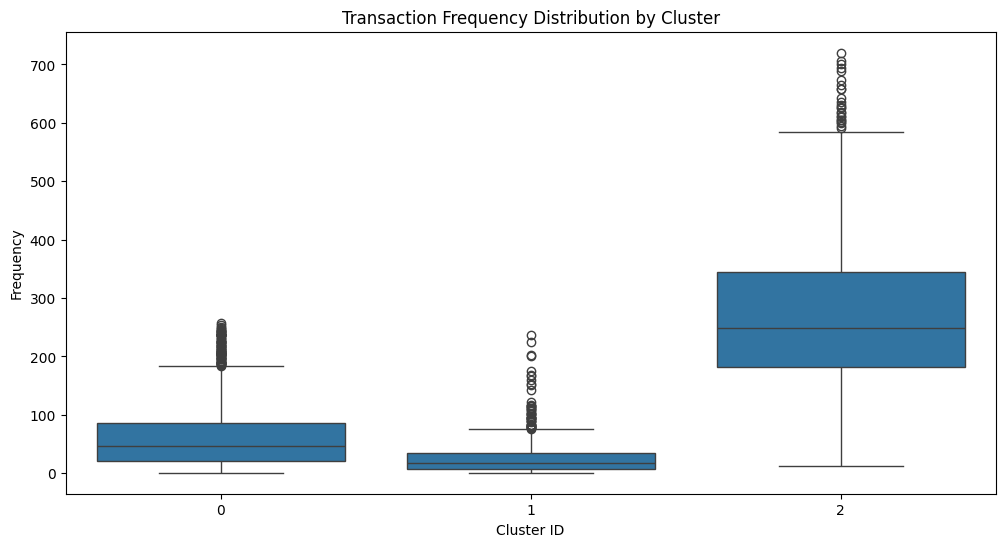

In [51]:
# Cell 38: Frequency by cluster
plt.figure(figsize=(12, 6))
sns.boxplot(x='ClusterID', y='Frequency', data=df_rfm)
plt.title('Transaction Frequency Distribution by Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Frequency')
plt.show()



In [52]:
df_rfm['ClusterID'] = kmeans.labels_
df_rfm.head(10)

,Customer ID,Amount,Frequency,Recency,ClusterID,Hierarchical_Cluster
0,12346.0,-64.68,46,66,0,0
1,12347.0,1323.32,71,2,0,0
2,12348.0,222.16,20,73,0,0
3,12349.0,2646.99,107,42,0,0
4,12351.0,300.93,21,10,0,0
5,12352.0,343.80,18,10,0,0
6,12353.0,317.76,20,43,0,0
7,12355.0,488.21,22,202,1,0
8,12356.0,3562.25,84,15,0,0
10,12358.0,2719.01,58,10,0,0


<Axes: xlabel='ClusterID', ylabel='Amount'>

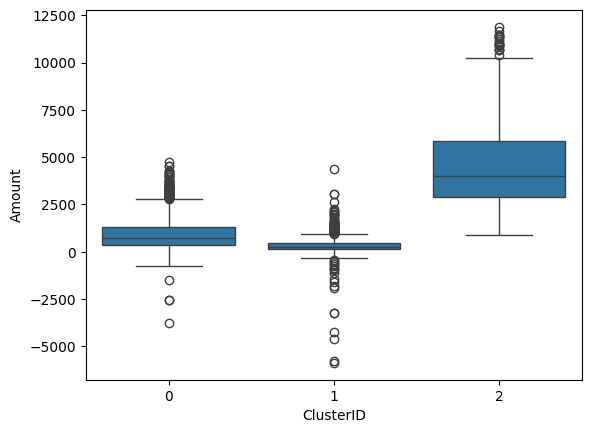

In [53]:
# plotting cluster ID vs amount
sns.boxplot(x='ClusterID', y='Amount', data=df_rfm)

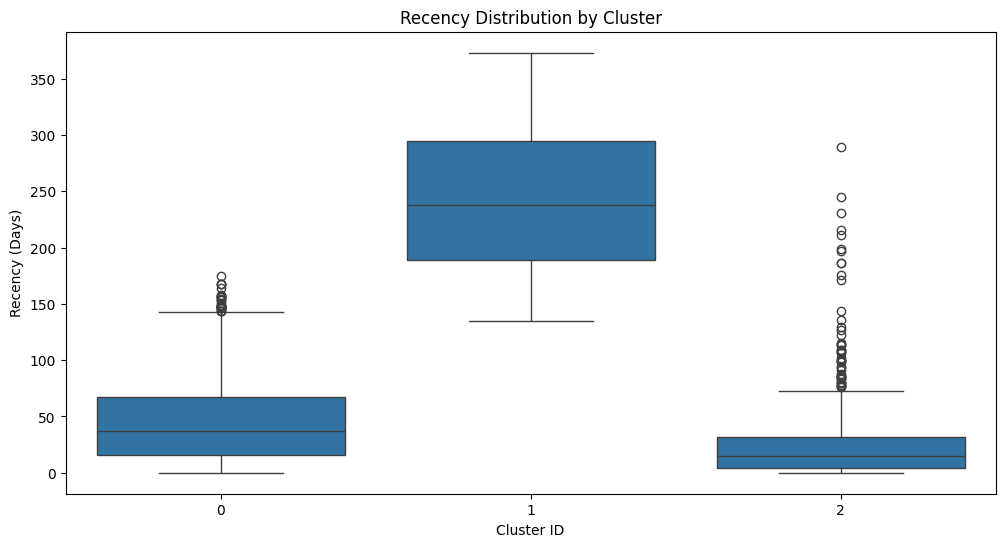

In [61]:
# Cell 39: Recency by cluster
plt.figure(figsize=(12, 6))
sns.boxplot(x='ClusterID', y='Recency', data=df_rfm)
plt.title('Recency Distribution by Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Recency (Days)')
plt.show()



<Figure size 1400x800 with 0 Axes>

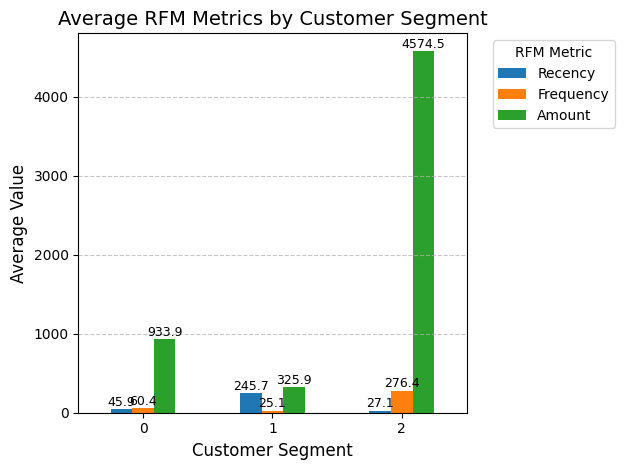

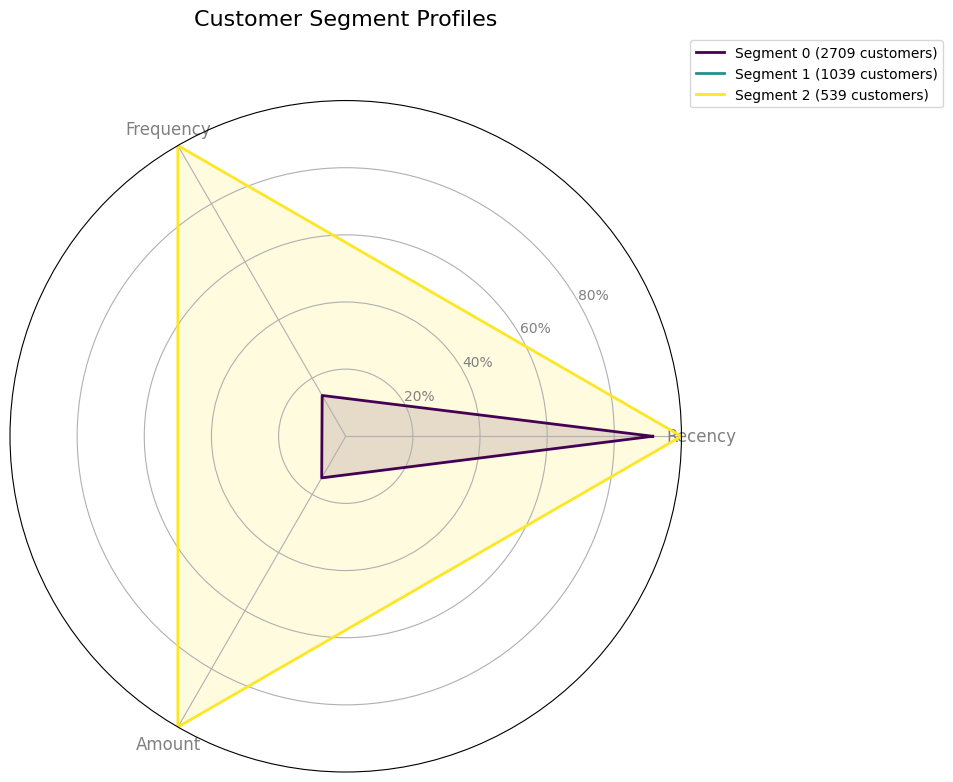


Customer Segment Profiles:
------------------------------------------
Recency: Lower values = more recent purchases
Frequency: Higher values = more transactions
Amount: Higher values = more money spent

Segment 0 Profile:
- Customers: 2709
- Recency: 45.9 days
- Frequency: 60.4 transactions
- Monetary: $933.93
------------------------------------------
Segment 1 Profile:
- Customers: 1039
- Recency: 245.7 days
- Frequency: 25.1 transactions
- Monetary: $325.94
------------------------------------------
Segment 2 Profile:
- Customers: 539
- Recency: 27.1 days
- Frequency: 276.4 transactions
- Monetary: $4574.46
------------------------------------------


In [63]:
# Grouped Bar Chart with Sequential Cluster IDs
# First, create sequential cluster labels
df_rfm['Sequential_Cluster'] = df_rfm['ClusterID'].astype('category').cat.codes

cluster_means = df_rfm.groupby('Sequential_Cluster')[['Recency', 'Frequency', 'Amount']].mean()

plt.figure(figsize=(14, 8))
ax = cluster_means.plot(kind='bar', rot=0)
plt.title('Average RFM Metrics by Customer Segment', fontsize=14)
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Average Value', fontsize=12)
plt.legend(title='RFM Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points',
                fontsize=9)
    
plt.tight_layout()
plt.show()

# Radar Chart with Sequential Clusters
from math import pi
import numpy as np

# Calculate mean values for each sequential cluster
cluster_means = df_rfm.groupby('Sequential_Cluster')[['Recency', 'Frequency', 'Amount']].mean()

# Normalize metrics (0-1 scale)
cluster_means_normalized = cluster_means.copy()
for column in cluster_means_normalized.columns:
    if column == 'Recency':  # Lower recency is better
        cluster_means_normalized[column] = 1 - ((cluster_means[column] - cluster_means[column].min()) / 
                                              (cluster_means[column].max() - cluster_means[column].min() + 1e-9))
    else:  # Higher frequency/amount is better
        cluster_means_normalized[column] = (cluster_means[column] - cluster_means[column].min()) / \
                                          (cluster_means[column].max() - cluster_means[column].min() + 1e-9)

# Set up radar chart
categories = list(cluster_means_normalized.columns)
N = len(categories)

angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # Close the circle

plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)
plt.title('Customer Segment Profiles', size=16, y=1.1)

# Draw axis lines
plt.xticks(angles[:-1], categories, color='grey', size=12)
ax.set_rlabel_position(30)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["20%", "40%", "60%", "80%"], color="grey", size=10)
plt.ylim(0, 1)

# Create distinct colors
colors = plt.cm.viridis(np.linspace(0, 1, len(cluster_means_normalized)))

# Plot each cluster profile
for i in cluster_means_normalized.index:
    values = cluster_means_normalized.loc[i].values.flatten().tolist()
    values += values[:1]  # Close the circle
    
    # Plot the line
    ax.plot(angles, values, color=colors[i], linewidth=2, linestyle='solid', 
            label=f'Segment {i} ({len(df_rfm[df_rfm["Sequential_Cluster"]==i])} customers)')
    
    # Fill area
    ax.fill(angles, values, color=colors[i], alpha=0.15)

# Add legend and show
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.1))
plt.tight_layout()
plt.show()

# Print cluster profiles
print("\nCustomer Segment Profiles:")
print("------------------------------------------")
print("Recency: Lower values = more recent purchases")
print("Frequency: Higher values = more transactions")
print("Amount: Higher values = more money spent\n")

for i in cluster_means.index:
    print(f"Segment {i} Profile:")
    print(f"- Customers: {len(df_rfm[df_rfm['Sequential_Cluster']==i])}")
    print(f"- Recency: {cluster_means.loc[i]['Recency']:.1f} days")
    print(f"- Frequency: {cluster_means.loc[i]['Frequency']:.1f} transactions")
    print(f"- Monetary: ${cluster_means.loc[i]['Amount']:.2f}")
    print("------------------------------------------")

# Final Analysis

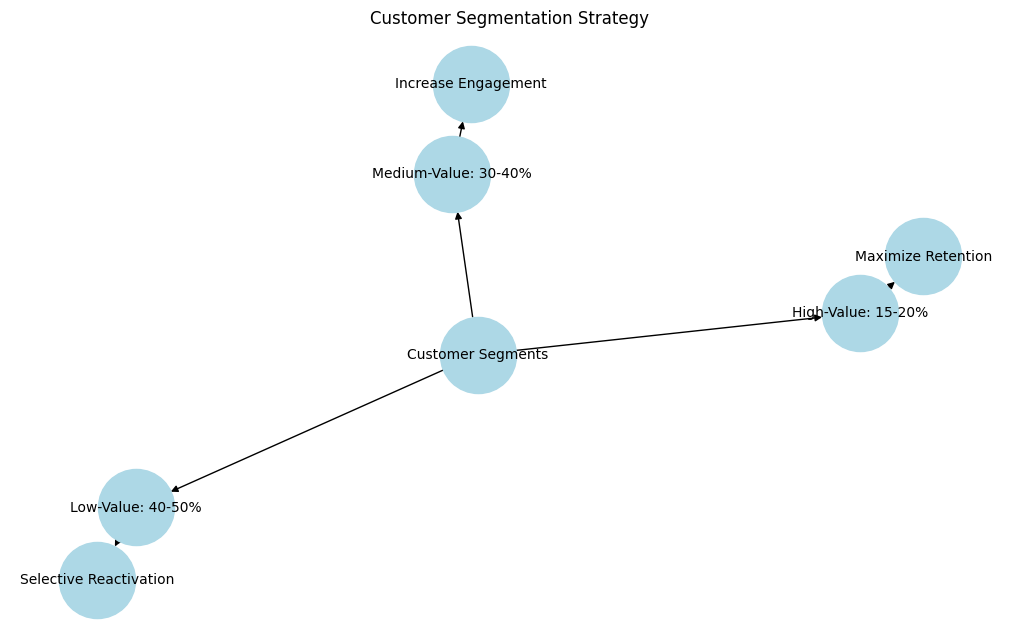

In [90]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Nodes
G.add_edges_from([
    ("Customer Segments", "High-Value: 15-20%"),
    ("Customer Segments", "Medium-Value: 30-40%"),
    ("Customer Segments", "Low-Value: 40-50%"),
    ("High-Value: 15-20%", "Maximize Retention"),
    ("Medium-Value: 30-40%", "Increase Engagement"),
    ("Low-Value: 40-50%", "Selective Reactivation")
])

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, arrows=True, node_color='lightblue', node_size=3000, font_size=10)
plt.title("Customer Segmentation Strategy")
plt.show()

# Segment-Specific Strategies


High-Value Segment (Cluster 0):

🎯 Characteristics: Recent purchases, high frequency, top spenders

💡 Retention Tactics:

Exclusive VIP Program: Tiered rewards with early product access

Personalized Experiences: Dedicated account managers and custom offers

Surprise & Delight: Unexpected gifts on purchase milestones

Premium Support: 24/7 priority customer service

Co-creation Opportunities: Invite to product development sessions



Medium-Value Segment (Cluster 1):

🎯 Characteristics: Moderate engagement, some recency concerns

💡 Retention Tactics:

Automated Win-Back Series: 3-stage email sequence after 45-day inactivity

Bundled Offers: "Frequently bought together" discounts

Loyalty Acceleration: Bonus points for repeat purchases

Personalized Replenishment: Automated reminders for frequently bought items

Community Building: Exclusive user groups/forums



Low-Value Segment (Cluster 2):

🎯 Characteristics: Low engagement, high recency, minimal spending

💡 Retention Tactics:

Reactivation Campaigns: 30-40% discount with free shipping

Feedback Incentives: $5 gift card for survey completion

Educational Content: "How to get maximum value" webinar series

Low-Cost Touchpoints: Quarterly newsletter with curated content

Sunset Pathway: Graceful exit program with referral incentive